# Telecom Customer Churn Prediction

### Problem Statement
- The high expense of attracting new clients compared to keeping current ones presents a constant problem for telecommunications businesses . In a market that is becoming more and more competitive , customer  churn  not only results in lost  revenue  but also in the loss of chances to upsell and cross-sell services. Using demographic data , account information , service usage , and payment information , this project seeks to create an end-to-end machine learning solution that can forecast client churn . Telecom businesses may optimize customer service efforts , adopt proactive retention measures , and eventually increase profitability and customer satisfaction by precisely identifying customers who are at risk of churning.

### About Dataset

 ##### Content
- Each row represents a customer, each column contains customer’s attributes 

 ##### The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents
 ##### Source:
- This dataset is available on Kaggle

## 1. Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
 from scipy.stats import chi2_contingency
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Import BayesSearchCV for Bayesian Optimization
from skopt import BayesSearchCV


# Exploratory Data Analysis (EDA)

## Load the dataset

In [8]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# Drop customerID as it's not useful for prediction
df.drop(columns=['customerID'], inplace=True)

In [11]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
# Check dataset shape and info

In [13]:
df.shape

(7043, 20)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [15]:
# Convert TotalCharges to numeric, coercing errors into NaN.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in TotalCharges with the median.
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [16]:
# Convert target 'Churn' from 'Yes'/'No' to numeric: 1 for 'Yes', 0 for 'No'.
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

 ## Find Missing Values

In [18]:
features_na = [features for features in df.columns if df[features].isnull().sum() > 0]
for feature in features_na:
    print(feature, np.round(df[feature].isnull().mean(), 4),  ' % missing values')
else:
    print("No missing value found")

No missing value found


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [20]:
#Checking Duplicates
print('There are',df.duplicated().sum(),'duplicate values in the dateset.') 

There are 22 duplicate values in the dateset.


In [21]:
# Removing duplicate rows
df = df.drop_duplicates()

# Confirm that duplicates have been removed
print('After removal, there are', df.duplicated().sum(), 'duplicate values in the dataset.')

After removal, there are 0 duplicate values in the dataset.


## Find Features with one value

In [23]:
for column in df.columns:
    print(column,df[column].nunique())

gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 73
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn 2


## Explore the Categorical Features

In [25]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O']
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [26]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is gender and number of categories are 2
The feature is Partner and number of categories are 2
The feature is Dependents and number of categories are 2
The feature is PhoneService and number of categories are 2
The feature is MultipleLines and number of categories are 3
The feature is InternetService and number of categories are 3
The feature is OnlineSecurity and number of categories are 3
The feature is OnlineBackup and number of categories are 3
The feature is DeviceProtection and number of categories are 3
The feature is TechSupport and number of categories are 3
The feature is StreamingTV and number of categories are 3
The feature is StreamingMovies and number of categories are 3
The feature is Contract and number of categories are 3
The feature is PaperlessBilling and number of categories are 2
The feature is PaymentMethod and number of categories are 4


## Find Categorical Feature Distribution

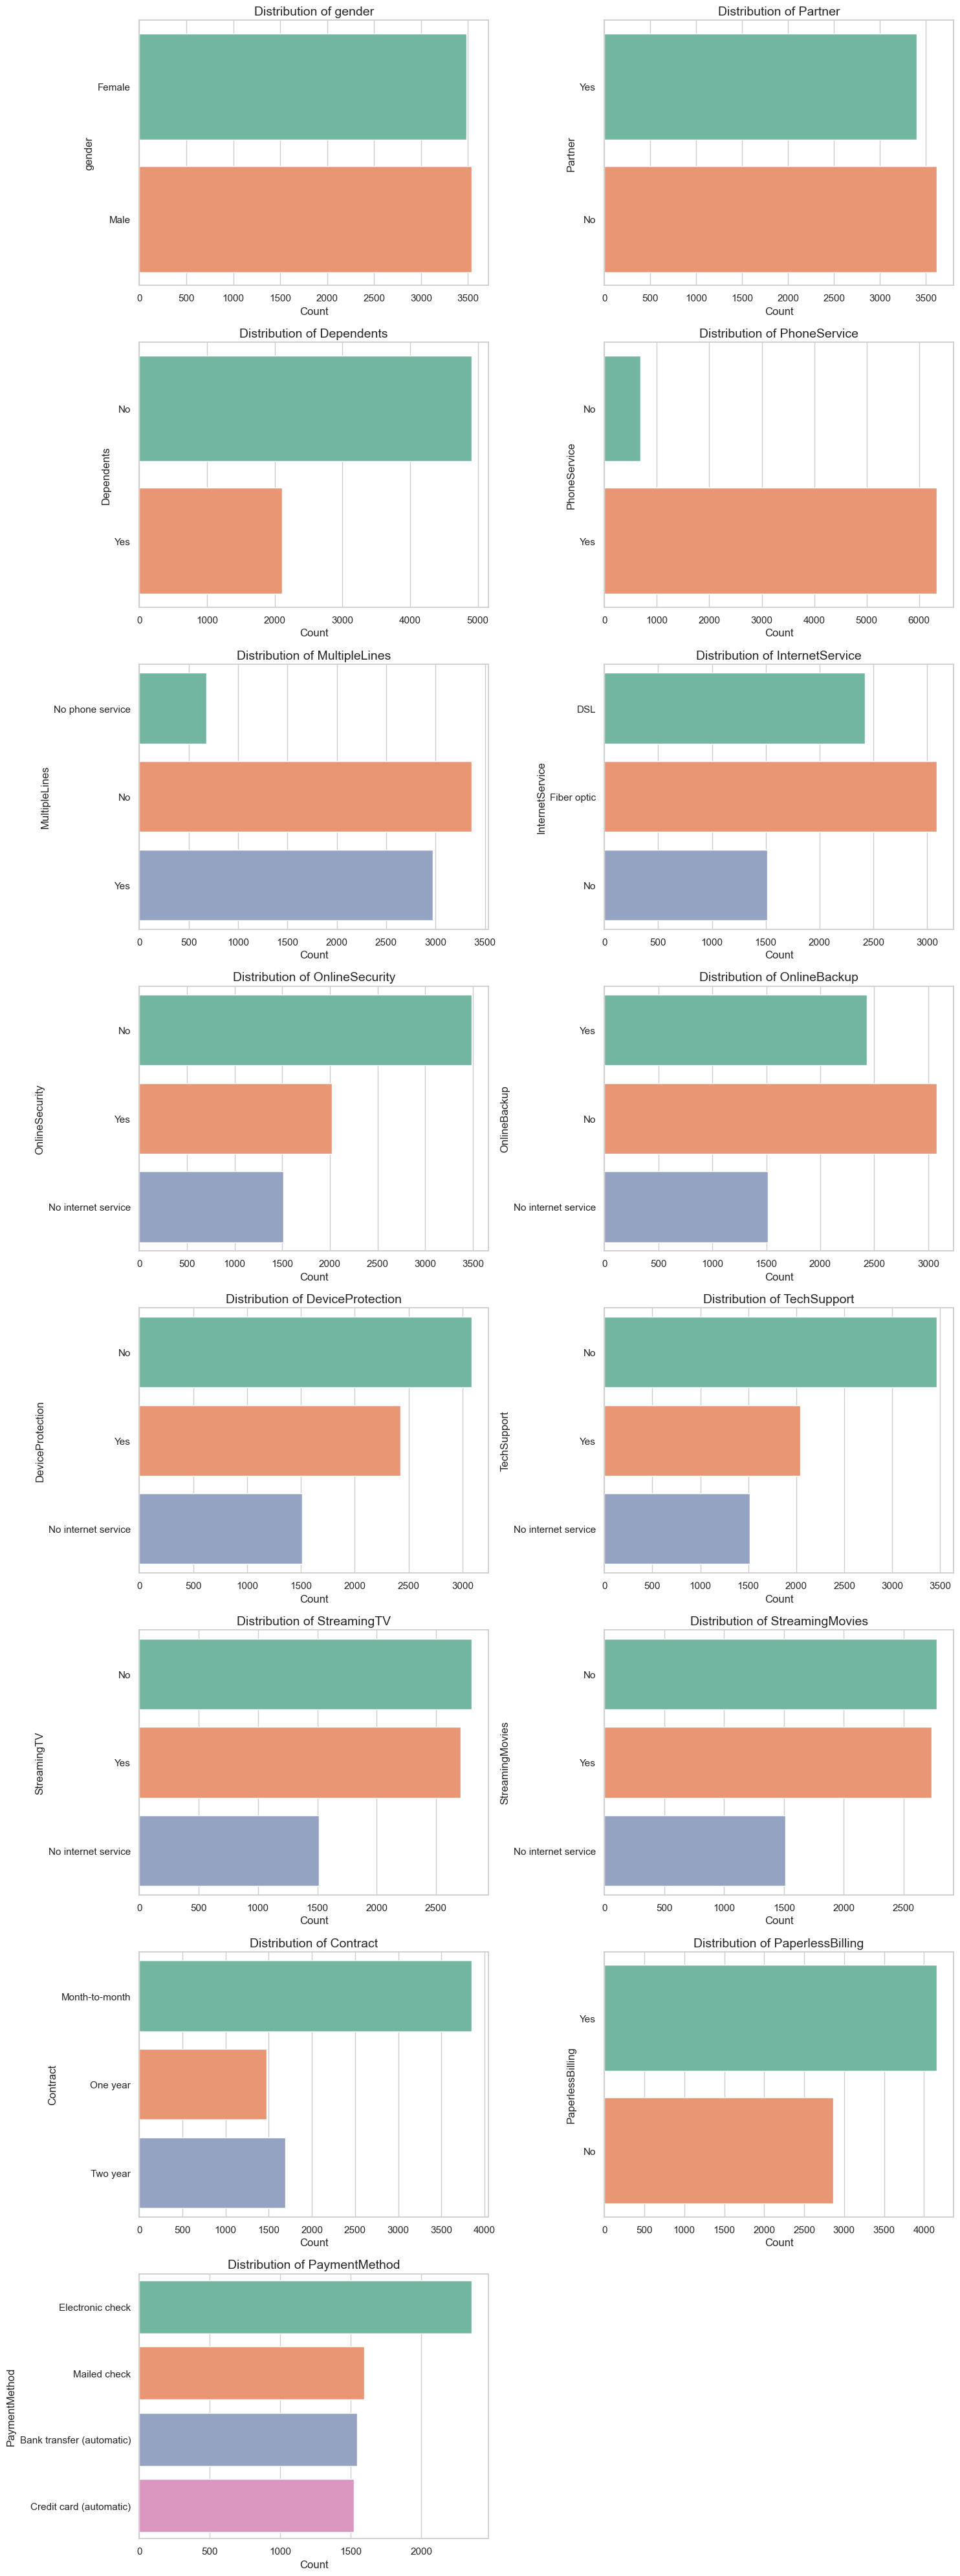

In [28]:

# Define the categorical features based on your output
categorical_features = [
'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection', 'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
]

# Set a clean and consistent seaborn theme
sns.set_theme(style="whitegrid")

# Determine the number of features and create a dynamic grid (2 columns)
num_features = len(categorical_features)
rows = num_features // 2 + num_features % 2  # two columns layout

fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows), facecolor='white')
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot each categorical feature using countplot, with hue set to the feature itself
for i, feature in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=df, y=feature, hue=feature, palette="Set2", dodge=False, ax=ax)
    
    # Remove the redundant legend since hue is the same as y
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    ax.set_xlabel("Count", fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.set_title(f"Distribution of {feature}", fontsize=14)

# Hide any extra subplot axes if the number of features is odd
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Relationship between Categorical Features and Label

### Visualization

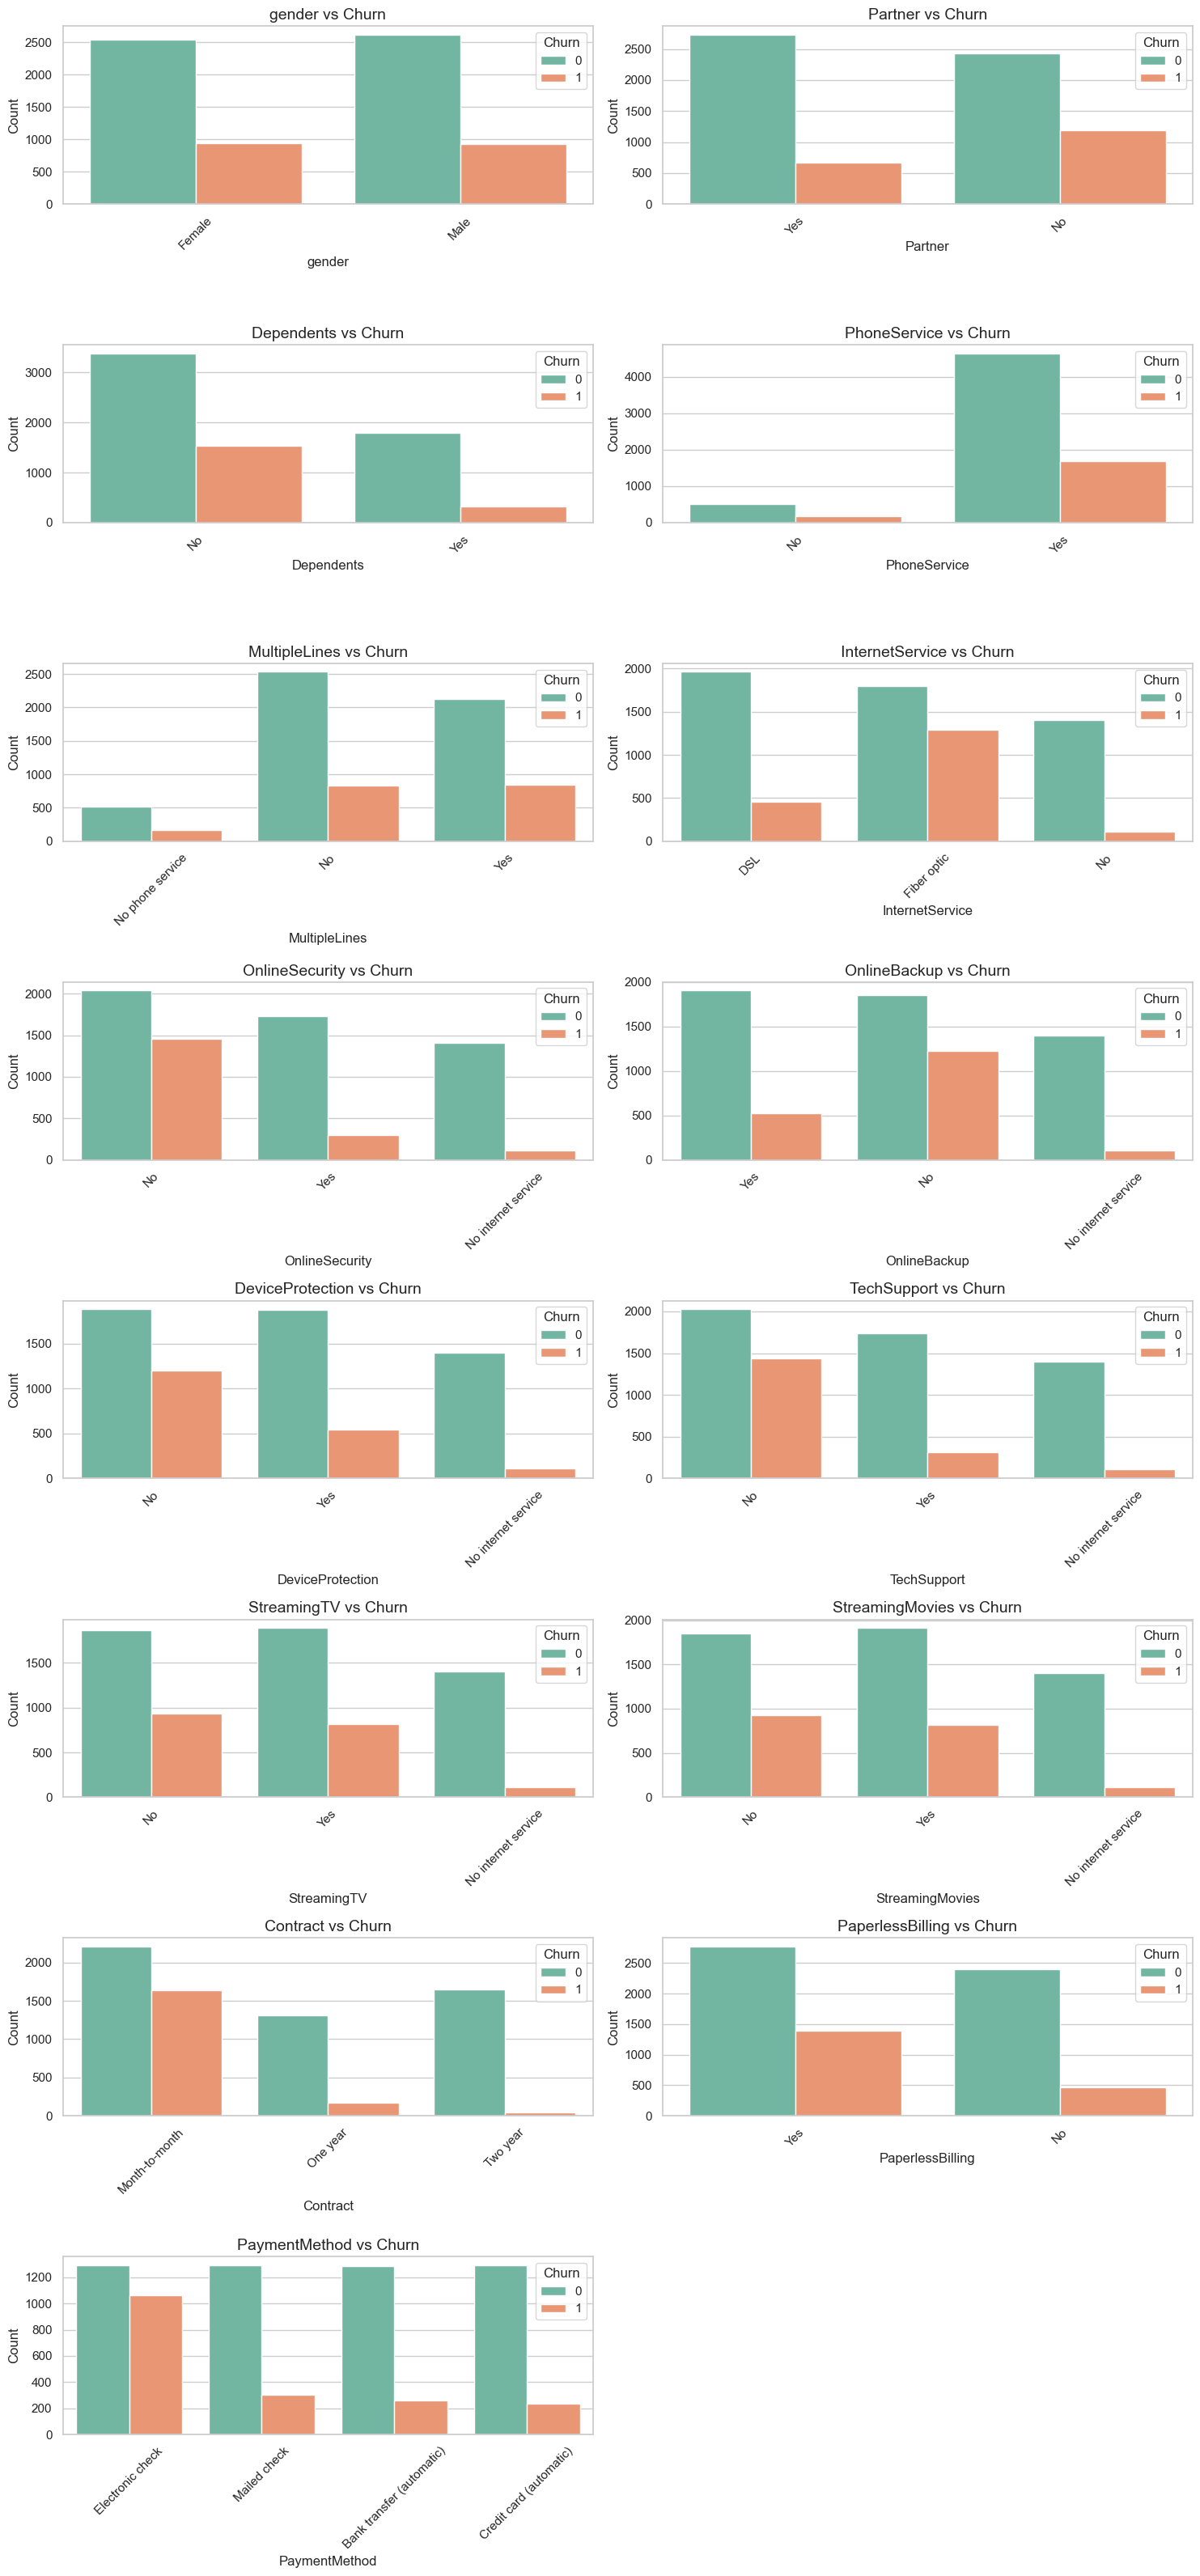

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Define categorical features
categorical_features = [
  'gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection', 'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
]

num_features = len(categorical_features)
rows = num_features // 2 + num_features % 2  # 2 columns layout
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=df, x=feature, hue='Churn', palette='Set2', ax=ax)
    ax.set_title(f"{feature} vs Churn", fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
# Hide any empty subplot axes if the number of features is odd
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
    
   


### Statistical Testing (Chi-Square)

In [33]:
print("Chi-Square Test Results:")
for feature in categorical_features:
    # Create a contingency table of the feature vs Churn
    contingency_table = pd.crosstab(df[feature], df['Churn'])
    
    # Perform the chi-square test of independence
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nFeature: {feature}")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p:.4f}")
    
    # You might consider a significance level of 0.05
    if p < 0.05:
        print("-> Statistically significant association with Churn.")
    else:
        print("-> No statistically significant association with Churn.")

Chi-Square Test Results:

Feature: gender
Chi-square statistic: 0.50
Degrees of freedom: 1
p-value: 0.4795
-> No statistically significant association with Churn.

Feature: Partner
Chi-square statistic: 155.48
Degrees of freedom: 1
p-value: 0.0000
-> Statistically significant association with Churn.

Feature: Dependents
Chi-square statistic: 186.79
Degrees of freedom: 1
p-value: 0.0000
-> Statistically significant association with Churn.

Feature: PhoneService
Chi-square statistic: 0.82
Degrees of freedom: 1
p-value: 0.3665
-> No statistically significant association with Churn.

Feature: MultipleLines
Chi-square statistic: 12.36
Degrees of freedom: 2
p-value: 0.0021
-> Statistically significant association with Churn.

Feature: InternetService
Chi-square statistic: 732.06
Degrees of freedom: 2
p-value: 0.0000
-> Statistically significant association with Churn.

Feature: OnlineSecurity
Chi-square statistic: 846.78
Degrees of freedom: 2
p-value: 0.0000
-> Statistically significant asso

## Explore the Numerical Features

In [35]:
# list of numerical variables
numerical_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Profit']))]
print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
df[numerical_features].head()

Number of numerical variables:  5


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,29.85,29.85,0
1,0,34,56.95,1889.50,0
2,0,2,53.85,108.15,1
3,0,45,42.30,1840.75,0
4,0,2,70.70,151.65,1


### Find Discrete Numerical Features

In [37]:
discrete_feature=[feature for feature in numerical_features if len(df[feature].unique())<25]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 2


In [38]:
print(discrete_feature)  


['SeniorCitizen', 'Churn']


In [39]:
# Remove 'SeniorCitizen' from numerical features
numerical_features = [feature for feature in numerical_features if feature != 'SeniorCitizen']

# Add 'SeniorCitizen' to categorical features 
if 'SeniorCitizen' not in categorical_features:
    categorical_features.append('SeniorCitizen')

# Convert 'SeniorCitizen' to a categorical type
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

# Print updated feature lists
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


<Axes: xlabel='SeniorCitizen', ylabel='count'>

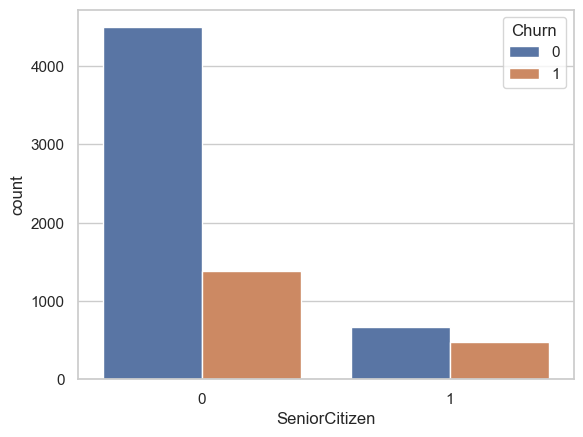

In [40]:
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)


### Find Continous Numerical Features

In [42]:
continuous_features=[feature for feature in numerical_features if feature not in discrete_feature+['Churn']]
print("Continuous feature Count {}".format(len(continuous_features)))

Continuous feature Count 3


In [43]:
continuous_features

['tenure', 'MonthlyCharges', 'TotalCharges']

### Distribution of Continous Numerical Features

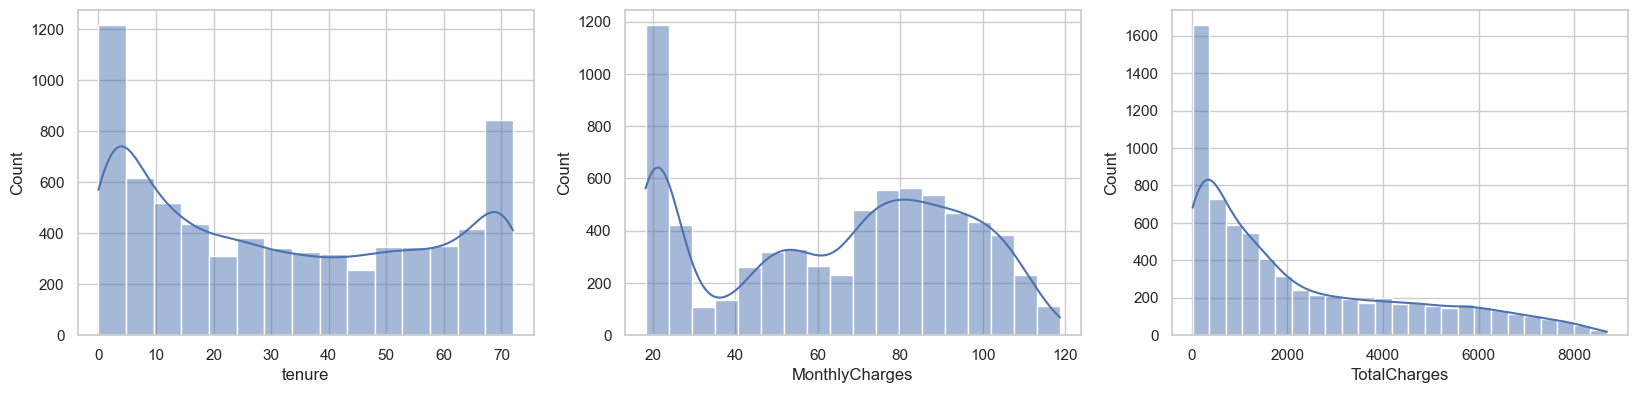

In [45]:
plt.figure(figsize=(20, 60), facecolor='white')
plotnumber = 1
for continuous_feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(df[continuous_feature], kde=True)
    plt.xlabel(continuous_feature)
    plotnumber += 1
plt.show()


### Relation between Continous numerical Features and Labels

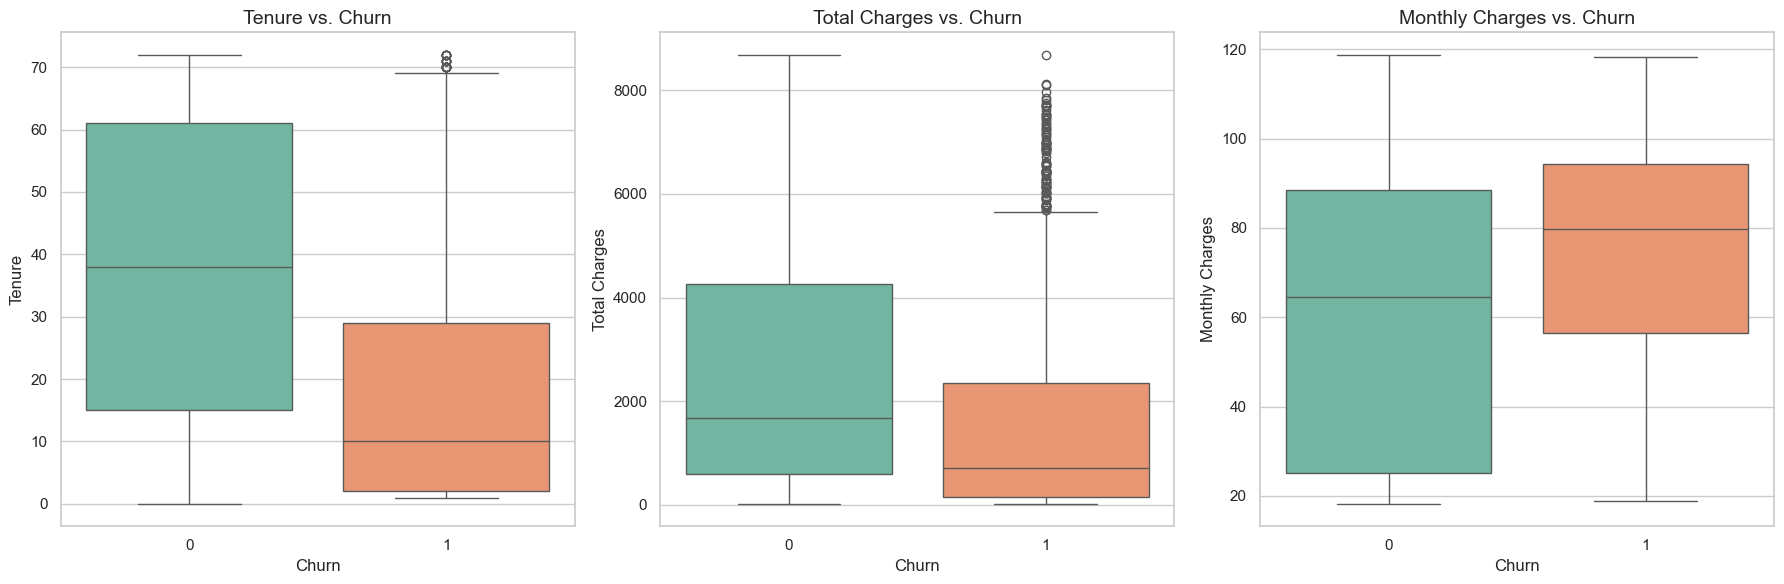

In [47]:

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')

# Boxplot for Tenure vs. Churn
sns.boxplot(x='Churn', y='tenure', data=df, palette='Set2', hue='Churn', dodge=False, ax=axes[0])
axes[0].set_title('Tenure vs. Churn', fontsize=14)
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Tenure', fontsize=12)
if axes[0].get_legend() is not None:
    axes[0].get_legend().remove()

# Boxplot for TotalCharges vs. Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df, palette='Set2', hue='Churn', dodge=False, ax=axes[1])
axes[1].set_title('Total Charges vs. Churn', fontsize=14)
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('Total Charges', fontsize=12)
if axes[1].get_legend() is not None:
    axes[1].get_legend().remove()

# Boxplot for MonthlyCharges vs. Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='Set2', hue='Churn', dodge=False, ax=axes[2])
axes[2].set_title('Monthly Charges vs. Churn', fontsize=14)
axes[2].set_xlabel('Churn', fontsize=12)
axes[2].set_ylabel('Monthly Charges', fontsize=12)
if axes[2].get_legend() is not None:
    axes[2].get_legend().remove()

plt.tight_layout()
plt.show()


### Find Outliers in numerical features

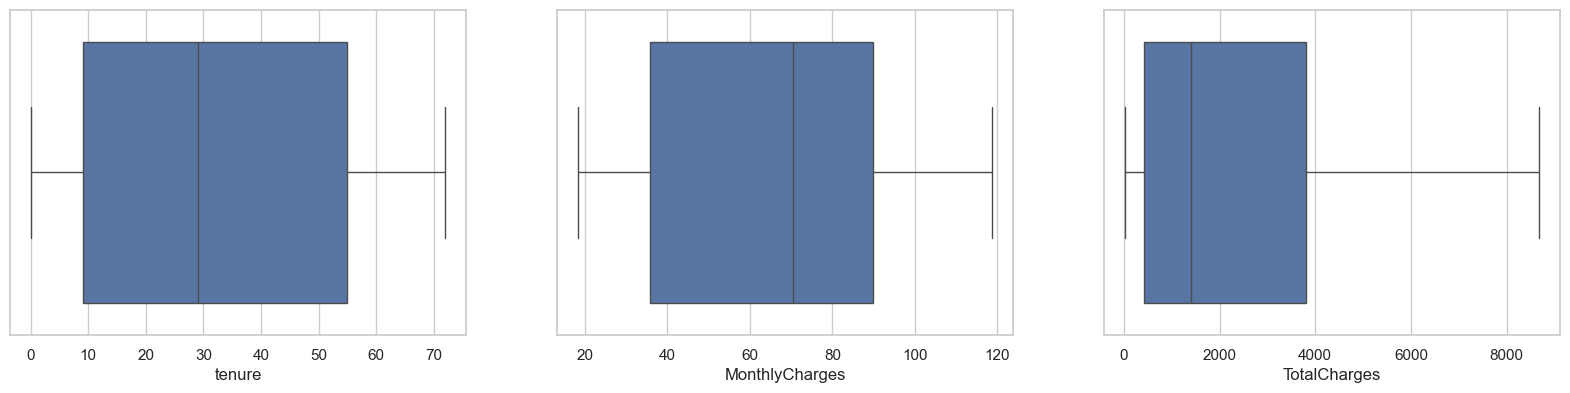

In [49]:
# Remove 'Churn' from the numerical_features list
filtered_numerical_features = [feature for feature in numerical_features if feature != 'Churn']

# Plot boxplots for the remaining numerical features
plt.figure(figsize=(20, 60), facecolor='white')
plotnumber = 1
for numerical_feature in filtered_numerical_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.boxplot(x=df[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber += 1
plt.show()

### Explore the Correlation between numerical features

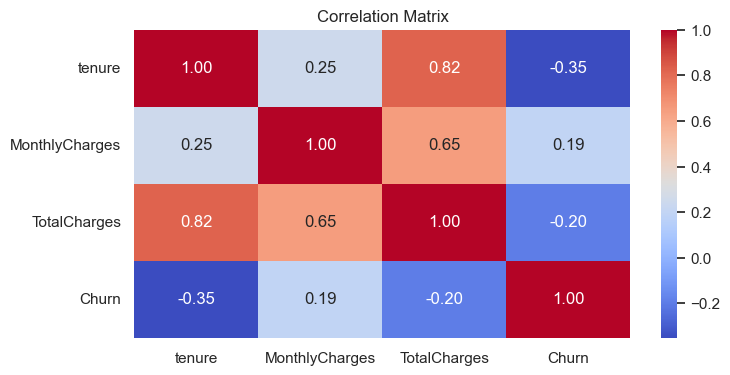

In [51]:
# Plot correlation heatmap for numerical features
plt.figure(figsize=(8, 4))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Data Preprocessing

In [53]:
# Drop features that are not statistically significant based on prior analysis.
df.drop(columns=['gender', 'PhoneService'], inplace=True)

## Train-Test Split

In [55]:
# Separate features and target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Split data (stratify to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set distribution:")
print(y_train.value_counts())


Training set distribution:
Churn
0    4131
1    1485
Name: count, dtype: int64


 ### Feature Engineering Transformer

In [57]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to add engineered features:
    - tenure_group: Binning tenure into groups.
    - AvgMonthlyCharge: TotalCharges divided by tenure (with fallback to MonthlyCharges if tenure is 0).
    """
    def __init__(self):
        pass

    def tenure_bin(self, tenure):
        if tenure <= 12:
            return '0-12'
        elif tenure <= 24:
            return '13-24'
        elif tenure <= 48:
            return '25-48'
        elif tenure <= 60:
            return '49-60'
        else:
            return '60+'
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Create tenure_group based on the tenure column.
        X['tenure_group'] = X['tenure'].apply(self.tenure_bin)
        # Create AvgMonthlyCharge; avoid division by zero.
        X['AvgMonthlyCharge'] = X.apply(lambda row: row['TotalCharges'] / row['tenure'] 
                                         if row['tenure'] > 0 else row['MonthlyCharges'], axis=1)
        return X


### Determine Preprocessing Columns from Transformed Training Data

In [59]:
# List of categorical features (including engineered 'tenure_group' and existing categorical features).
categorical_features = [
    'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
    'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'tenure_group'
]

# List of numerical features (existing plus engineered numerical features).
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge']

### Create Preprocessor Pipeline

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)


# Modeling Pipeline with SMOTE

In [63]:
def create_model_pipeline_smote(model):
    pipeline = ImbPipeline(steps=[
        ('feature_engineering', FeatureEngineer()),
        ('preprocessing', preprocessor),
        ('sampling', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    return pipeline

## Define Models

In [65]:
models = {

    "Logistic Regression": LogisticRegression(solver="liblinear", random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)


}

## Define Search Spaces for Bayesian Optimization

In [67]:

param_spaces =param_spaces = {
    "Logistic Regression": {
        "classifier__C": (0.1, 10.0, 'log-uniform'),
        "classifier__penalty": ['l1', 'l2']
    },
    "Random Forest": {
        "classifier__n_estimators": (50, 200),
        "classifier__max_depth": [5, 10, None],
        "classifier__min_samples_split": (2, 10)
    },
    "XGBoost": {
        "classifier__learning_rate": (0.01, 0.2, 'uniform'),
        "classifier__max_depth": (3, 7),
        "classifier__n_estimators": (50, 200)
    },
     "LightGBM": {
        "classifier__num_leaves": (20, 150),
        "classifier__max_depth": (3, 15),
        "classifier__learning_rate": (0.01, 0.3, 'uniform'),
        "classifier__n_estimators": (50,200)
     }
}

## Cross-Validation Strategy

In [69]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
cv_scores = {}

## Bayesian Optimization for Each Model

In [71]:
# Increased iterations for a thorough hyperparameter search.
for name, model in models.items():
    pipeline = create_model_pipeline_smote(model)
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_spaces[name],
        scoring="accuracy",
        cv=cv_strategy,
        n_iter=30,  
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    bayes_search.fit(X_train, y_train)
    best_models[name] = bayes_search.best_estimator_
    cv_scores[name] = bayes_search.best_score_
    print(f"{name}: Best CV Accuracy = {bayes_search.best_score_:.4f}")


Logistic Regression: Best CV Accuracy = 0.7532
Random Forest: Best CV Accuracy = 0.7922
XGBoost: Best CV Accuracy = 0.7927
LightGBM: Best CV Accuracy = 0.7917


 ## Select the Best Model Based on CV Accuracy

In [73]:
best_model_name = max(cv_scores, key=cv_scores.get)
best_pipeline = best_models[best_model_name]
print(f"\nBest Model Selected: {best_model_name}")



Best Model Selected: XGBoost


## Evaluation on Test Data

In [75]:
y_pred = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Test Accuracy: 0.7907

Confusion Matrix:
[[874 159]
 [135 237]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1033
           1       0.60      0.64      0.62       372

    accuracy                           0.79      1405
   macro avg       0.73      0.74      0.74      1405
weighted avg       0.80      0.79      0.79      1405



# Model Deployment

## Save the Best Model Pipeline

In [77]:
with open("best_churn_model_bayes.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)
print("\nBest model saved as 'best_churn_model_bayes.pkl'")


Best model saved as 'best_churn_model_bayes.pkl'


## Loading the Saved Model

In [126]:
with open("best_churn_model_bayes.pkl", "rb") as f:
    model = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!


## Preparing Sample Data for Testing

In [138]:
sample_data = {
    "tenure": [36],
    "MonthlyCharges": [80.0],
    "TotalCharges": [2880.0],
    "Partner": ["No"],
    "Dependents": ["No"],
    "MultipleLines": ["Yes"],
    "InternetService": ["Fiber optic"],
    "OnlineSecurity": ["No"],
    "OnlineBackup": ["No"],
    "DeviceProtection": ["Yes"],
    "TechSupport": ["No"],
    "StreamingTV": ["Yes"],
    "StreamingMovies": ["Yes"],
    "Contract": ["Two year"],
    "PaperlessBilling": ["No"],
    "PaymentMethod": ["Credit card (automatic)"],
    "SeniorCitizen": ["1"]
}

sample_df = pd.DataFrame(sample_data)
print(sample_df)

   tenure  MonthlyCharges  TotalCharges Partner Dependents MultipleLines  \
0      36            80.0        2880.0      No         No           Yes   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0     Fiber optic             No           No              Yes          No   

  StreamingTV StreamingMovies  Contract PaperlessBilling  \
0         Yes             Yes  Two year               No   

             PaymentMethod SeniorCitizen  
0  Credit card (automatic)             1  


## Making Predictions with the Model

In [140]:
# Get the prediction and probabilities
prediction = model.predict(sample_df)
prediction_proba = model.predict_proba(sample_df)

# Convert the numeric prediction to a text label and get the corresponding probability
if prediction[0] == 1:
    result = "Churn"
    prob = prediction_proba[0][1]
else:
    result = "No Churn"
    prob = prediction_proba[0][0]

# Format the probability as a percentage with two decimal places
formatted_prob = f"{prob * 100:.2f}%"

print("Prediction:", f"{result} ({formatted_prob})")


Prediction: No Churn (91.63%)
